# Modelo de nieve en el Deva
***
_Autor:_    __Jesús Casado__ <br> _Revisión:_ __6/12/2019__ <br>

__Introducción__<br>
Se aplica el método grado-día sobre un caso ejemplo, la cuenca alta del río Deva.

__Cosas a mejorar__ <br>
* La temperatura a usar puede ser la mínima o la media. Analizar.
* Reclasificar datos de MODIS en binarios (cubierto, no cubierto, NaN para nubes).
* Reclasficiar resultados del modelo grado-día.
* Combinar datos de Terra y Aqua para evitar huecos.

***

__Índice__ <br>
[__1. Datos__](#1.-Datos)<br>
[1.1 Nieve MODIS](#1.1-Nieve-MODIS)<br>
[1.2 Precipitación y temperatura](#1.2-Precipitación-y-temperatura)<br>
[1.3 Radiación](#1.3-Radiación)<br>

[__2. Método de grado-día__](#2.-Método-de-grado-día)<br>

[__3. Rendimiento__](#3.-Rendimiento)<br>

In [41]:
import os
import numpy as np
import numpy.ma as ma
import pandas as pd
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import seaborn as sns
sns.set()
from netCDF4 import Dataset
from datetime import date, datetime, timedelta
import geopandas as gpd
from calendar import monthrange

In [42]:
rutaBase = os.getcwd().replace('\\', '/') + '/'

In [43]:
%run funciones_modelo_nieve.ipynb
%run funciones_raster.ipynb
%run funciones_rendimiento_espacial.ipynb

In [45]:
%run class_MODIS.ipynb

## 1. Datos

### 1.1 Cartografía

In [46]:
# ruta cartografía
rutaGIS = os.path.join(rutaBase, '../data/GIS/')

# importar polígonos de las cuencas
cuenca = gpd.read_file(rutaGIS + "mask_465_deva.shp")

# importar mdt de la cuenca
DEM = read_ascii(rutaGIS + 'dem_465_deva.asc', crs=25830)
DEM.variable = 'elevación'
DEM.units = 'm.s.n.m'

### 1.2 Nieve MODIS

In [47]:
# Cargar netCDF con los datos climáticos
rutaMODIS = os.path.join(rutaBase, '../data/SnowCover/')
nc = Dataset(rutaMODIS + 'MODIS_Maximum_Snow_Extent_Terra+Aqua.nc', 'r', format='NETCDF4')

# extraer datos
data = nc['SC'][::]
units = nc['SC'].units
# fechas
times = np.array([datetime(1, 1, 1).date() + timedelta(time) for time in nc['time'][:].data])
# coordenadas
X = nc['X'][:].data
Y = nc['Y'][:].data
crs = CRS.from_epsg(nc.coordinateSystem.split(':')[1])

# guardar como objeto raster3D
SCobs = raster3D(data, X, Y, times, variable='snow cover', label='SC', units=units,
                   crs=crs)

nc.close()

#### Fechas de MODIS

In [48]:
# definir fechas de inicio y fin de los datos de MODIS
start, end = SCobs.times.min(), SCobs.times.max()
start = datetime(start.year, start.month, 1).date()
end = datetime(end.year, end.month, monthrange(end.year, end.month)[1]).date()

### 1.3 Precipitación y temperatura

In [49]:
# Cargar netCDF con los datos climáticos
rutaClima = os.path.join(rutaBase, '../data/clima/')
nc = Dataset(rutaClima + 'clima_1265.nc', 'r', format='NETCDF4')

# extraer variables
X = nc['X'][:].data
Y = nc['Y'][:].data
dates = nc['time'][:].data
dates = np.array([date(1979, 1, 1) + timedelta(days=int(d)) for d in dates])
pcp = nc['pcp'][::].data
tmp = nc['tmp'][::].data

nc.close()

In [50]:
# guardar como objetos raster3D
PCP = raster3D(pcp, X, Y, dates, units='mm', variable='Precipitación', label='P',
            crs=CRS.from_epsg(25830))

TMP = raster3D(tmp, X, Y, dates, units='°C', variable='Temperatura', label='T',
            crs=CRS.from_epsg(25830))

In [51]:
# recortar a las fechas de MODIS
PCP.extraer(start, end, axis=0, inplace=True)
TMP.extraer(start, end, axis=0, inplace=True)

In [52]:
# enmascarar celdas sin ningún dato
PCP.enmascararNaN()
TMP.enmascararNaN()

### 1.4 Radiación

In [58]:
rad = np.zeros((12, *DEM.data.shape)) * np.nan
for i in range(1, 7):
    asci = read_ascii(rutaClima + 'rad{0:02d}.asc'.format(i))
    radi = asci.data
    if i == 1:
        # arrays de coorenadas
        ncols, nrows, xll, yll, cs, noDATA = asci.attributes
        Xrad = np.arange(xll, xll + cs *ncols, cs)
        Yrad = np.arange(yll, yll + cs *nrows, cs)[::-1]
        # recortar filas y columnas sin dato
        radi, Xrad, Yrad = corregirRaster(radi, Xrad, Yrad)
    else:
        # recortar filas y columnas sin dato
        radi = corregirRaster(radi)
    # asignar mapa
    rad[i-1,:,:] = radi.copy()
    rad[12-i,:,:] = radi.copy()

In [59]:
# guardar como objeto raster3D
RAD = raster3D(rad, Xrad, Yrad, np.arange(1, 13), variable='radiación', units='-',
               label='Rad', crs=CRS.from_epsg(25830))
RAD.enmascararNaN()

### 1.5 Mapas de las variables

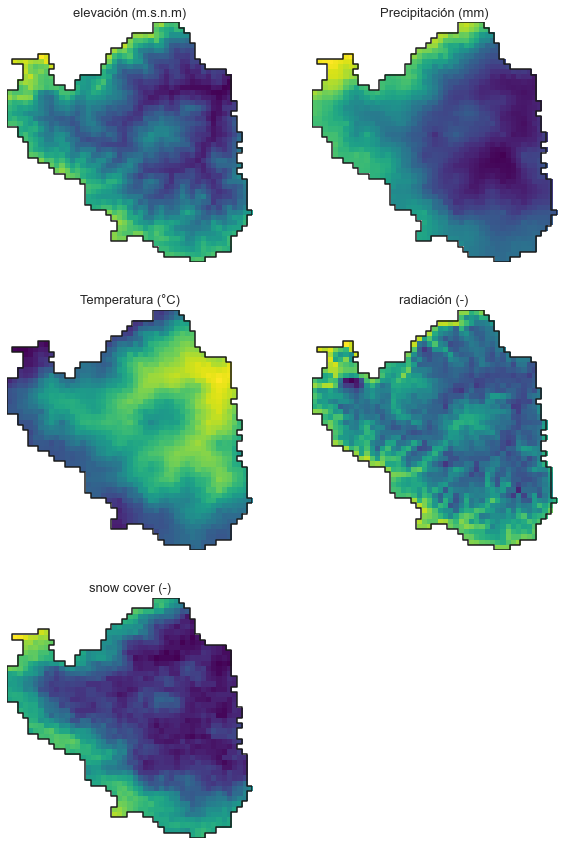

In [60]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(10, 15))

for Var, ax in zip([DEM, PCP, TMP, RAD, SCobs], axes.flatten()):
    try:
        im = ax.imshow(np.nanmean(Var.data, axis=0), cmap='viridis', extent=Var.extent())
    except:
        im = ax.imshow(Var.data, cmap='viridis', extent=Var.extent)
    cuenca.boundary.plot(ax=ax, edgecolor='k')

    ax.set_title('{0} ({1})'.format(Var.variable, Var.units), fontsize=13)
    ax.set_aspect('equal')
    ax.axis('off');
    
axes[2,1].axis('off');

## 2. Método de grado-día

### 2.1 Cálculo sin radiación

In [61]:
# calcular modelo de nieve
SWE, SM = degreeDayMethod(PCP, TMP, RAD=None, Ts=0., Tb=0., DDF1=2., DDF2=4., verbose=True)

# reclasificar SWE en un mapa binario
SCsim = snowCover(SWE, threshold=1)

# agregar simulación a paso 8 días
SCsim8 = remuestrearMODIS(SCobs, SCsim, func='max')

### 2.2 Cálculo con radiación

In [62]:
# calcular modelo de nieve
SWErad, SMrad = degreeDayMethod(PCP, TMP, RAD=RAD, Ts=0., Tb=0., DDF1=2., DDF2=4., verbose=True)

# reclasificar SWE en un mapa binario
SCradsim = snowCover(SWErad, threshold=1)

# agregar simulación a paso 8 días
SCradsim8 = remuestrearMODIS(SCobs, SCradsim, func='max')

### 2.3 Comparativa

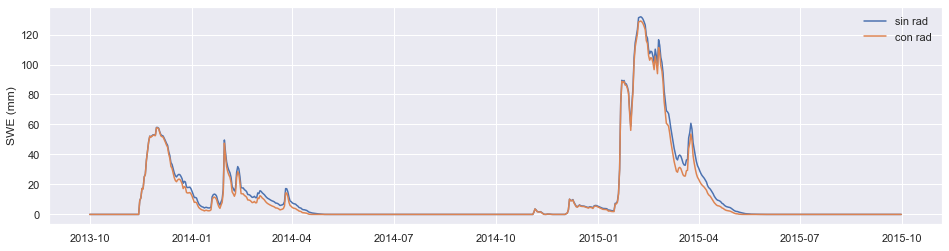

In [63]:
serie1 = pd.Series(np.nanmean(SWE.data, axis=(1,2)), index=SWE.times)
serie2 = pd.Series(np.nanmean(SWErad.data, axis=(1,2)), index=SWErad.times)

plt.figure(figsize=(16, 4))
plt.ylabel('SWE (mm)')
plt.plot(serie1, label='sin rad')
plt.plot(serie2, label='con rad')
plt.legend();

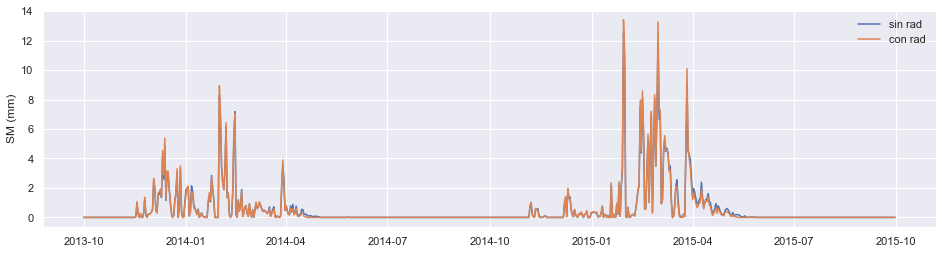

In [64]:
serie1 = pd.Series(np.nanmean(SM.data, axis=(1,2)), index=SM.times)
serie2 = pd.Series(np.nanmean(SMrad.data, axis=(1,2)), index=SMrad.times)

plt.figure(figsize=(16, 4))
plt.ylabel('SM (mm)')
plt.plot(serie1, label='sin rad');
plt.plot(serie2, label='con rad');
plt.legend();

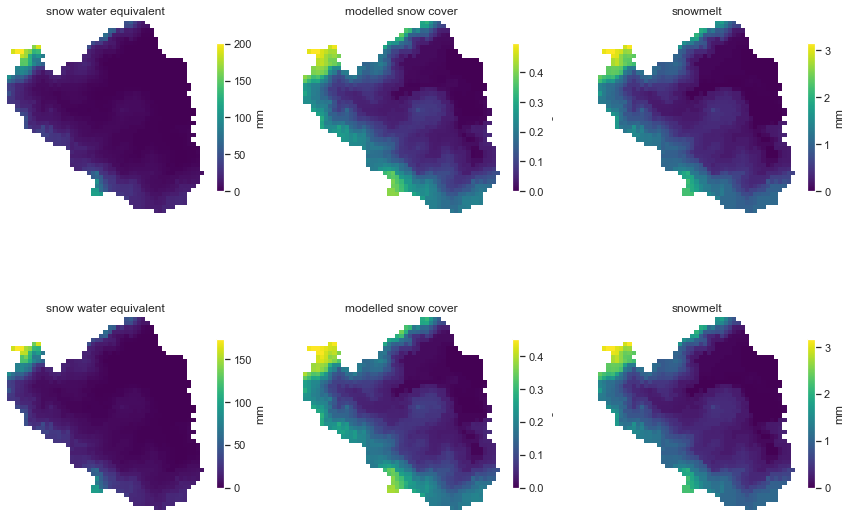

In [65]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))

for (ax, Var) in zip(axes.flatten(), [SWE, SCsim, SM, SWErad, SCradsim, SMrad]):
    # mapa de precipitación media
    im = ax.imshow(Var.data.mean(axis=0), extent=Var.extent(), cmap='viridis')
    cb = plt.colorbar(im, shrink=.6, ax=ax)
    cb.set_label(Var.units)
    ax.set_title(Var.variable)
    ax.axis('off');

2013-12-27


C:\ProgramFiles\Anaconda3\envs\geo_env\lib\site-packages\matplotlib\colors.py:576: RuntimeWarning: overflow encountered in multiply
  xa *= self.N


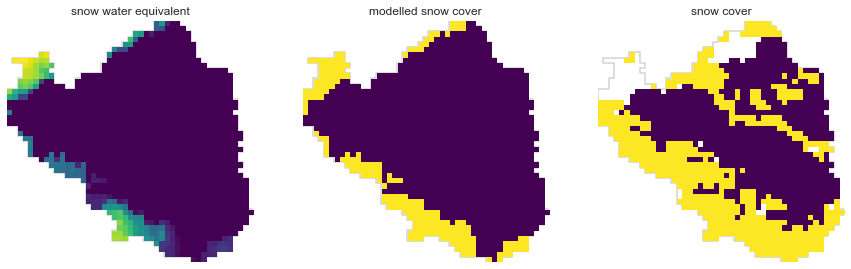

In [66]:
time = times[10]
print(time)
fig, axes = plt.subplots(ncols=3, figsize=(15, 5))

for ax, Var in zip(axes, [SWE, SCsim, SCobs]):
    #cuenca.plot(color='lightgray', ax=ax, zorder=0, alpha=.25)
    cuenca.boundary.plot(color='lightgray', ax=ax, zorder=0)
    Var.plot(time=time, ax=ax)
    ax.set_title(Var.variable)
    ax.axis('off')

```Python
fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(20, 10))
extent = [X.min(), X.max(), Y.min(), Y.max()]

# mapa de precipitación media
im = ax[0,0].imshow(pcp_i, extent=extent)
cb = plt.colorbar(im, shrink=.6, ax=ax[0,0])
cb.set_label('mm')
ax[0,0].set_title('Precipitación {0}'.format(date))
ax[0,0].axis('off');

# mapa de temperatura media
im = ax[0,1].imshow(tmp_i, extent=extent)
cb = plt.colorbar(im, shrink=.6, ax=ax[0,1])
cb.set_label('C')
ax[0,1].set_title('Temperatura {0}'.format(date))
ax[0,1].axis('off');

# equivalente agua-nieve inicial
im = ax[0,2].imshow(swe_0, extent=extent)
cb = plt.colorbar(im, shrink=.6, ax=ax[0,2])
cb.set_label('mm')
ax[0,2].set_title('equivalente agua-nieve {0}'.format(dates_[i-1]))
ax[0,2].axis('off');

ax[0,3].axis('off')

# precipitación en forma de nieve
im = ax[1,0].imshow(snowfall)
cb = plt.colorbar(im, shrink=.6, ax=ax[1,0])
cb.set_label('mm')
ax[1,0].set_title('snowfall')
ax[1,0].axis('off');

# fusión potencial
im = ax[1,1].imshow(snowmelt)
cb = plt.colorbar(im, shrink=.6, ax=ax[1,1])
cb.set_label('mm')
ax[1,1].set_title('snowmelt (P)')
ax[1,1].axis('off');

# fusión real
im = ax[1,2].imshow(snowmelt_)
cb = plt.colorbar(im, shrink=.6, ax=ax[1,2])
cb.set_label('mm')
ax[1,2].set_title('snowmelt (R)')
ax[1,2].axis('off');

# equivalente agua-nieve
im = ax[1,3].imshow(swe_i)
cb = plt.colorbar(im, shrink=.6, ax=ax[1,3])
cb.set_label('mm')
ax[1,3].set_title('swe')
ax[1,3].axis('off');
```

## 3 Rendimiento

### 3.1 SPAEF
```Python
# SPAEF en un único paso temporal
t = 10
spaef = SPAEF(SCobs.data[t,:,:], SCsim8.data[t,:,:], verbose=True, plot=True)

# serie temporal de SPAEF
spaef = pd.Series(index=SCsim8.times, dtype=float)
for t, time in enumerate(spaef.index):
    spaef[time] = SPAEF(SCobs.data[t,:,:], SCsim8.data[t,:,:], verbose=False)

print('SPAEF = {0:.3f}'.format(spaef.mean()))
plt.plot(spaef);
```
### 3.2 KGE
```Python
# KGE en un día concreto
t = 10
kge = KGEsp(SCobs.data[t,:,:], SCsim8.data[t,:,:], verbose=True, plot=True)

# serie temporal de KGE
kge = pd.Series(index=SCsim8.times, dtype=float)
for t, time in enumerate(kge.index):
    kge[time] = KGEsp(SCobs.data[t,:,:], SCsim.data[t,:,:], verbose=False)

print('KGE = {0:.3f}'.format(kge.mean()))
plt.plot(kge);
```

### 3.3 f1
#### Sin radiación

f1 = 0.868


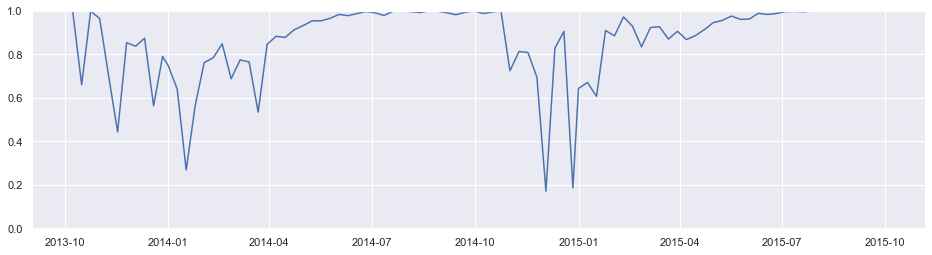

In [67]:
# rendimiento en f1_score
f1Serie = rendimiento_clasificacion(SCobs, SCsim8, score='f1')
f1Mean = f1Serie.mean()

print('f1 = {0:.3f}'.format(f1Mean.round(3)))
plt.figure(figsize=(16, 4))
plt.plot(f1Serie)
plt.ylim(0, 1);

#### Con radiación

f1 = 0.879


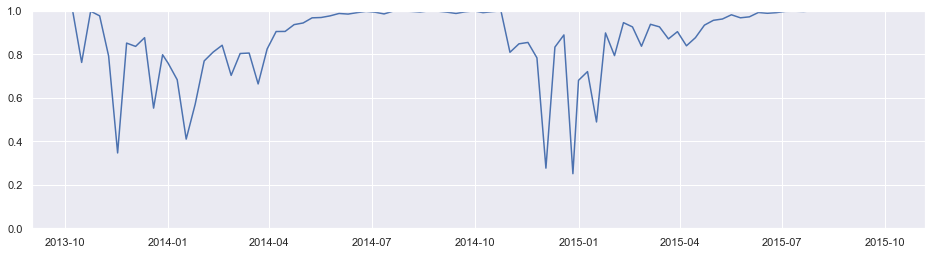

In [68]:
# rendimiento en f1_score
f1radSerie = rendimiento_clasificacion(SCobs, SCradsim8, score='f1', average='micro')
f1radMean = f1radSerie.mean()

print('f1 = {0:.3f}'.format(f1radMean.round(3)))
plt.figure(figsize=(16, 4))
plt.plot(f1radSerie)
plt.ylim(0, 1);

In [85]:
# definir colores
colors = np.array([[255, 255, 255 , 0], [33, 178, 171, 130]])
colors = colors / 255.
cmap = ListedColormap(colors)
boundaries = [0, .5, 1]
norm = BoundaryNorm(boundaries, cmap.N, clip=True)
snow_patch = mpatches.Patch(color=cmap.colors[1], label='snow')

In [86]:
# definir límites del mapa
xmin, ymin, xmax, ymax = cuenca.bounds.values[0]
xmin -= DEM.cellsize * 2
ymin -= DEM.cellsize * 2
xmax += DEM.cellsize * 2
ymax += DEM.cellsize * 2
extent = [xmin, xmax, ymin, ymax]

2014-03-06
f1 = 0.775


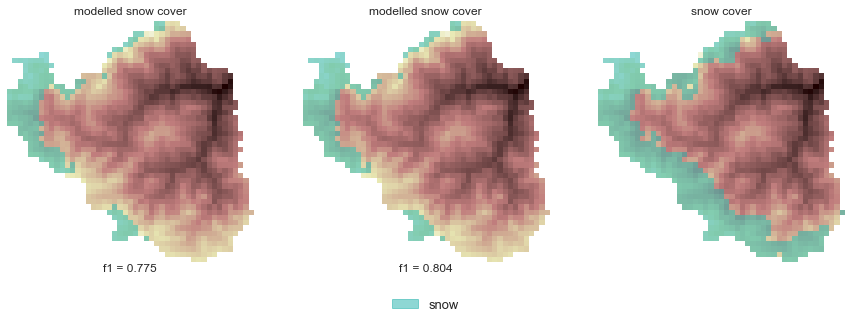

In [89]:
t = 19
time = SCsim8.times[t]
print(time)
fig, axes = plt.subplots(ncols=3, figsize=(15, 5))

print('f1 = {0:.3f}'.format(f1Serie[time]))
for i, (ax, Var, f1) in enumerate(zip(axes, [SCsim8, SCradsim8, SCobs], [f1Serie, f1radSerie, None])):
    #cuenca.plot(color='lightgray', ax=ax, zorder=0, alpha=.25)
    ax.imshow(DEM.data, extent=DEM.extent, cmap='pink')
    im = ax.imshow(Var.data[t,:,:], extent=Var.extent(), cmap=cmap, norm=norm)
    if i in [0, 1]:
        ax.text(0.5, -0.04, 'f1 = {0:.3f}'.format(f1[time]), horizontalalignment='center', fontsize=12,
                transform=ax.transAxes)
    ax.set_title(Var.variable)
    ax.axis('off');
fig.legend(handles=[snow_patch], loc=8, fontsize=13);

Exportando archivo C:/Users/jcr693/Documents/GitHub/Calibrar/notebooks/../output/SC_simulado_vs_observado.mp4


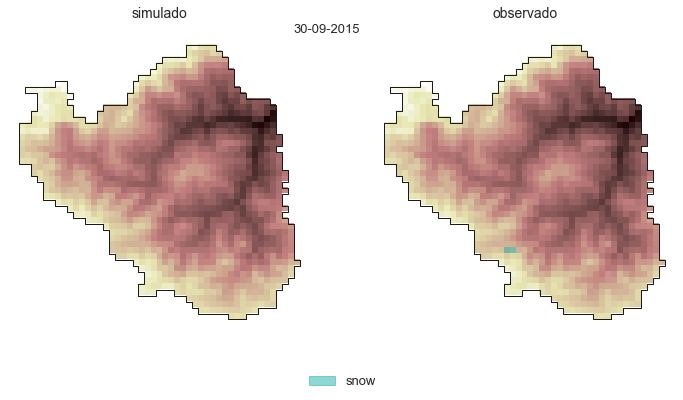

In [79]:
rutaOut = os.path.join(rutaBase, '../output/')
mp4File = rutaOut + 'SC_simulado_vs_observado.mp4'
video2(SCradsim8, SCobs, cuenca, cmap, norm, DEM, figsize=(12, 6), extent=extent,
       labels=['simulado', 'observado'], export=mp4File)